<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepNLP-END2.0/blob/main/09_NLP_Evaluation/ClassificationEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip3 install git+https://github.com/extensive-nlp/ttc_nlp --quiet
! pip3 install torchmetrics --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.4MB 8.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 10.3MB 46.7MB/s 
     |████████████████████████████████| 10.8MB 188kB/s 
     |████████████████████████████████| 819kB 37.3MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 624kB 42.7MB/s 
     |████████████████████████████████| 10.1MB 46.9MB/s 
     |████████████████████████████████| 460kB 45.3MB/s 
     |████████████████████████████████| 645kB 38.8MB/s 
     |████████████████████████████████| 112kB 55.0MB/s 
     |████████████████████████████████| 235kB 52.7MB/s 
     |█████████████████

In [ ]:
from ttctext.datamodules.sst import SSTDataModule
from ttctext.datasets.sst import StanfordSentimentTreeBank

In [ ]:
sst_dataset = SSTDataModule(batch_size=128)
sst_dataset.setup()

Cached Downloading: sst_dataset.zip
Downloading...
From: https://drive.google.com/uc?id=1urNi0Rtp9XkvkxxeKytjl1WoYNYUEoPI
To: /root/.cache/gdown/tmp0azbz08d/dl
5.04MB [00:00, 197MB/s]


File exists: sst_dataset.zip


In [ ]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy, precision, recall, confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

class SSTModel(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.num_classes = self.hparams.output_dim

        self.embedding = nn.Embedding(self.hparams.input_dim, self.hparams.embedding_dim)

        self.lstm = nn.LSTM(
            self.hparams.embedding_dim, 
            self.hparams.hidden_dim, 
            num_layers=self.hparams.num_layers,
            dropout=self.hparams.dropout,
            batch_first=True
        )

        self.proj_layer = nn.Sequential(
            nn.Linear(self.hparams.hidden_dim, self.hparams.hidden_dim),
            nn.BatchNorm1d(self.hparams.hidden_dim),
            nn.ReLU(),
            nn.Dropout(self.hparams.dropout),
        )

        self.fc = nn.Linear(self.hparams.hidden_dim, self.num_classes)

        self.loss = nn.CrossEntropyLoss()

    def init_state(self, sequence_length):
        return (torch.zeros(self.hparams.num_layers, sequence_length, self.hparams.hidden_dim).to(self.device),
                torch.zeros(self.hparams.num_layers, sequence_length, self.hparams.hidden_dim).to(self.device))

    def forward(self, text, text_length, prev_state=None):

        # [batch size, sentence length] => [batch size, sentence len, embedding size]
        embedded = self.embedding(text)

        # packs the input for faster forward pass in RNN
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            embedded, text_length.to('cpu'), 
            enforce_sorted=False, 
            batch_first=True
        )
        
        # [batch size sentence len, embedding size] => 
        #   output: [batch size, sentence len, hidden size]
        #   hidden: [batch size, 1, hidden size]
        packed_output, curr_state = self.lstm(packed, prev_state)

        hidden_state, cell_state = curr_state

        # print('hidden state shape: ', hidden_state.shape)
        # print('cell')

        # unpack packed sequence
        # unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # print('unpacked: ', unpacked.shape)

        # [batch size, sentence len, hidden size] => [batch size, num classes]
        # output = self.proj_layer(unpacked[:, -1])
        output = self.proj_layer(hidden_state[-1])

        # print('output shape: ', output.shape)

        output = self.fc(output)

        return output, curr_state

    def shared_step(self, batch, batch_idx):
        label, text, text_length = batch

        logits, in_state = self(text, text_length)
        
        loss = self.loss(logits, label)

        pred = torch.argmax(F.log_softmax(logits, dim=1), dim=1)
        acc = accuracy(pred, label)

        metric = {'loss': loss, 'acc': acc, 'pred': pred, 'label': label}

        return metric


    def training_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, batch_idx)

        log_metrics = {'train_loss': metrics['loss'], 'train_acc': metrics['acc']}

        self.log_dict(log_metrics, prog_bar=True)

        return metrics


    def validation_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, batch_idx)

        return metrics
    

    def validation_epoch_end(self, outputs):
        acc = torch.stack([x['acc'] for x in outputs]).mean()
        loss = torch.stack([x['loss'] for x in outputs]).mean()

        log_metrics = {'val_loss': loss, 'val_acc': acc}

        self.log_dict(log_metrics, prog_bar=True)

        if self.trainer.sanity_checking:
            return log_metrics

        preds = torch.cat([x['pred'] for x in outputs]).view(-1)
        labels = torch.cat([x['label'] for x in outputs]).view(-1)

        accuracy_ = accuracy(preds, labels)
        precision_ = precision(preds, labels, average='macro', num_classes=self.num_classes)
        recall_ = recall(preds, labels, average='macro', num_classes=self.num_classes) 
        classification_report_ = classification_report(labels.cpu().numpy(), preds.cpu().numpy(), target_names=self.hparams.class_labels)
        confusion_matrix_ = confusion_matrix(preds, labels, num_classes=self.num_classes)
        cm_df = pd.DataFrame(confusion_matrix_.cpu().numpy(), index=self.hparams.class_labels, columns=self.hparams.class_labels)

        print(f'Test Epoch {self.current_epoch}/{self.hparams.epochs-1}: F1 Score: {accuracy_:.5f}, Precision: {precision_:.5f}, Recall: {recall_:.5f}\n')
        print(f'Classification Report\n{classification_report_}')

        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap = sns.heatmap(cm_df, annot=True, ax=ax, fmt='d') # font size
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=45)
        locs, labels = plt.yticks()
        plt.setp(labels, rotation=45)

        plt.show()

        print("\n")

        return log_metrics


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        accuracy = torch.stack([x['acc'] for x in outputs]).mean()

        self.log('hp_metric', accuracy)

        self.log_dict({'test_acc': accuracy}, prog_bar=True)


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = {
            'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True),
            'monitor': 'train_loss',
            'name': 'scheduler'
        }
        return [optimizer], [lr_scheduler]


In [ ]:
from omegaconf import OmegaConf

In [ ]:
hparams = OmegaConf.create({
    'input_dim': len(sst_dataset.get_vocab()),
    'embedding_dim': 128,
    'num_layers': 2,
    'hidden_dim': 64,
    'dropout': 0.5,
    'output_dim': len(StanfordSentimentTreeBank.get_labels()),
    'class_labels': sst_dataset.raw_dataset_train.get_labels(),
    'lr': 5e-4,
    'epochs': 10,
    'use_lr_finder': False
})

In [ ]:
sst_model = SSTModel(hparams)

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=1, reload_dataloaders_every_epoch=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | embedding  | Embedding        | 3.1 M 
1 | lstm       | LSTM             | 82.9 K
2 | proj_layer | Sequential       | 4.3 K 
3 | fc         | Linear           | 325   
4 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.785    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Epoch 0/9: F1 Score: 0.27718, Precision: 0.26534, Recall: 0.22052

Classification Report
               precision    recall  f1-score   support

very negative       0.00      0.00      0.00       270
     negative       0.32      0.45      0.37       603
      neutral       0.33      0.02      0.04       376
     positive       0.25      0.62      0.35       491
very positive       0.43      0.01      0.02       385

     accuracy                           0.28      2125
    macro avg       0.27      0.22      0.16      2125
 weighted avg       0.28      0.28      0.20      2125



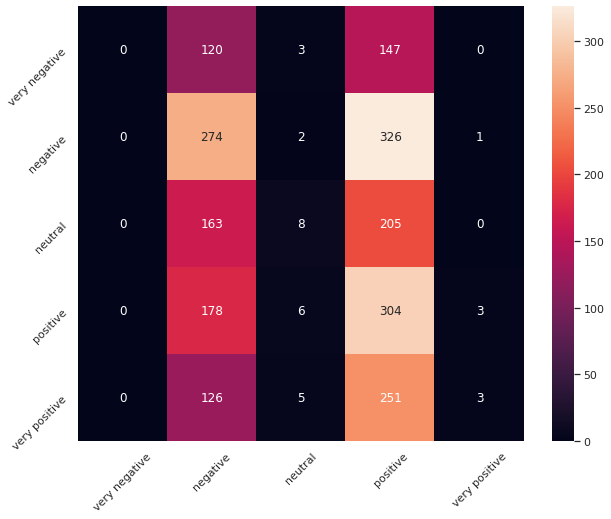

Validating: 0it [00:00, ?it/s]

Test Epoch 1/9: F1 Score: 0.30353, Precision: 0.21953, Recall: 0.24048

Classification Report
               precision    recall  f1-score   support

very negative       0.00      0.00      0.00       270
     negative       0.37      0.51      0.43       603
      neutral       0.00      0.00      0.00       376
     positive       0.26      0.67      0.38       491
very positive       0.47      0.02      0.04       385

     accuracy                           0.30      2125
    macro avg       0.22      0.24      0.17      2125
 weighted avg       0.25      0.30      0.21      2125



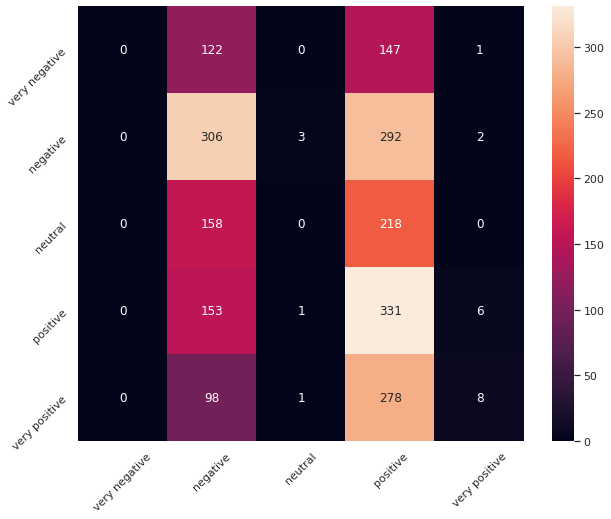

Validating: 0it [00:00, ?it/s]

Test Epoch 2/9: F1 Score: 0.32424, Precision: 0.29089, Recall: 0.25676

Classification Report
               precision    recall  f1-score   support

very negative       0.00      0.00      0.00       270
     negative       0.37      0.57      0.45       603
      neutral       0.30      0.02      0.03       376
     positive       0.28      0.66      0.40       491
very positive       0.50      0.03      0.06       385

     accuracy                           0.32      2125
    macro avg       0.29      0.26      0.19      2125
 weighted avg       0.31      0.32      0.24      2125



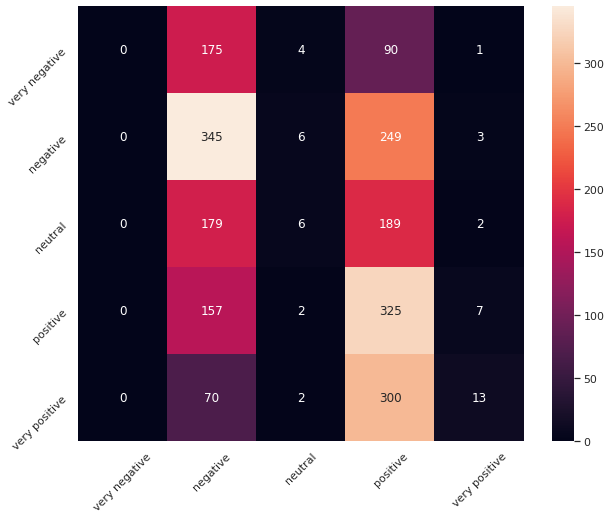

Validating: 0it [00:00, ?it/s]

Test Epoch 3/9: F1 Score: 0.34306, Precision: 0.29051, Recall: 0.27536

Classification Report
               precision    recall  f1-score   support

very negative       0.00      0.00      0.00       270
     negative       0.42      0.53      0.47       603
      neutral       0.26      0.03      0.06       376
     positive       0.30      0.79      0.43       491
very positive       0.47      0.02      0.04       385

     accuracy                           0.34      2125
    macro avg       0.29      0.28      0.20      2125
 weighted avg       0.32      0.34      0.25      2125



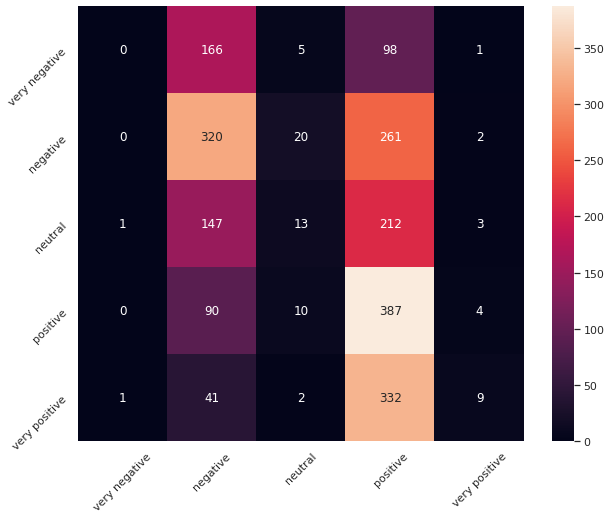

Validating: 0it [00:00, ?it/s]

Test Epoch 4/9: F1 Score: 0.38118, Precision: 0.31285, Recall: 0.31416

Classification Report
               precision    recall  f1-score   support

very negative       0.00      0.00      0.00       270
     negative       0.42      0.60      0.50       603
      neutral       0.26      0.05      0.08       376
     positive       0.33      0.70      0.45       491
very positive       0.55      0.22      0.32       385

     accuracy                           0.38      2125
    macro avg       0.31      0.31      0.27      2125
 weighted avg       0.34      0.38      0.32      2125



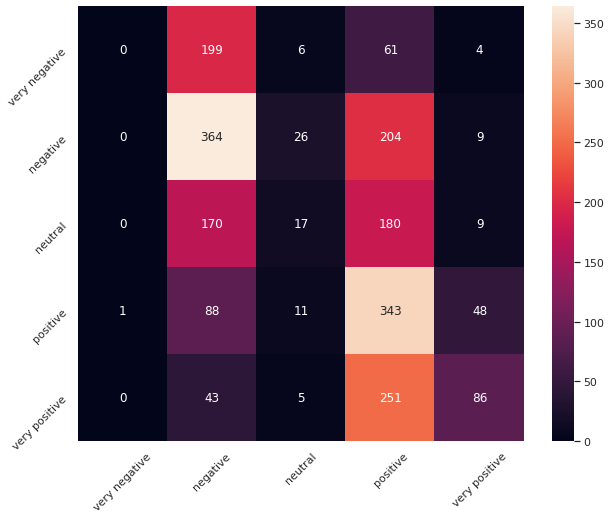

Validating: 0it [00:00, ?it/s]

Test Epoch 5/9: F1 Score: 0.39671, Precision: 0.39571, Recall: 0.33487

Classification Report
               precision    recall  f1-score   support

very negative       0.35      0.07      0.12       270
     negative       0.44      0.63      0.52       603
      neutral       0.25      0.06      0.10       376
     positive       0.34      0.66      0.45       491
very positive       0.60      0.25      0.35       385

     accuracy                           0.40      2125
    macro avg       0.40      0.33      0.31      2125
 weighted avg       0.40      0.40      0.35      2125



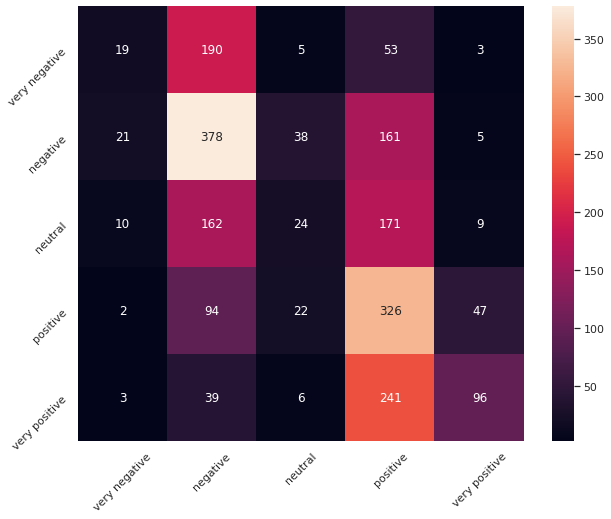

Validating: 0it [00:00, ?it/s]

Test Epoch 6/9: F1 Score: 0.39247, Precision: 0.38170, Recall: 0.32815

Classification Report
               precision    recall  f1-score   support

very negative       0.27      0.04      0.08       270
     negative       0.44      0.65      0.52       603
      neutral       0.23      0.10      0.14       376
     positive       0.35      0.64      0.45       491
very positive       0.62      0.21      0.31       385

     accuracy                           0.39      2125
    macro avg       0.38      0.33      0.30      2125
 weighted avg       0.39      0.39      0.34      2125



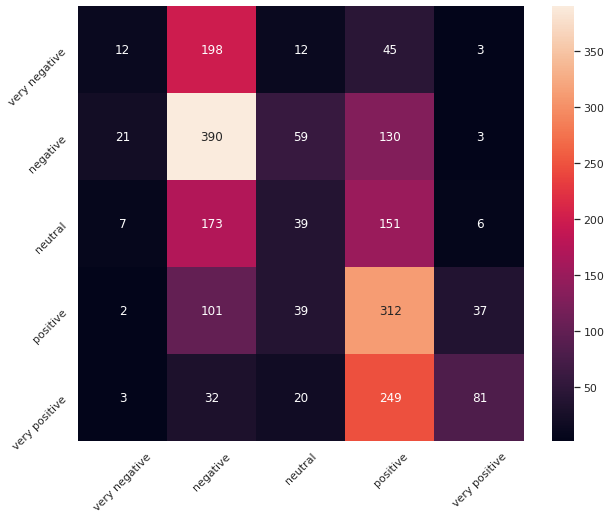

Validating: 0it [00:00, ?it/s]

Test Epoch 7/9: F1 Score: 0.41271, Precision: 0.41481, Recall: 0.35720

Classification Report
               precision    recall  f1-score   support

very negative       0.31      0.10      0.15       270
     negative       0.44      0.65      0.52       603
      neutral       0.29      0.19      0.23       376
     positive       0.38      0.57      0.46       491
very positive       0.66      0.27      0.39       385

     accuracy                           0.41      2125
    macro avg       0.41      0.36      0.35      2125
 weighted avg       0.42      0.41      0.38      2125



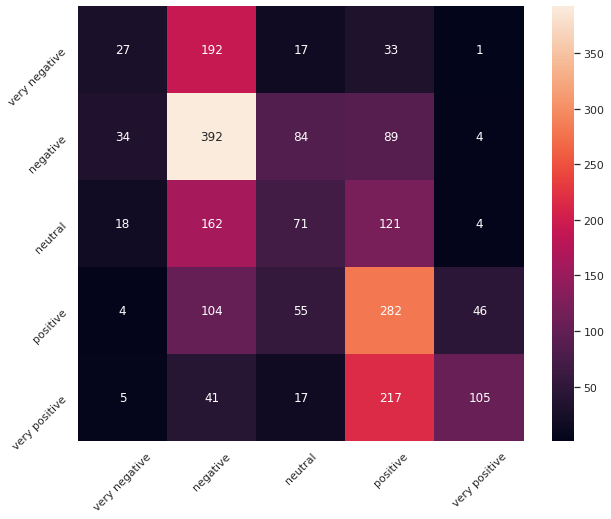

Validating: 0it [00:00, ?it/s]

Test Epoch 8/9: F1 Score: 0.39812, Precision: 0.39687, Recall: 0.37210

Classification Report
               precision    recall  f1-score   support

very negative       0.32      0.25      0.28       270
     negative       0.43      0.50      0.46       603
      neutral       0.25      0.22      0.23       376
     positive       0.38      0.48      0.42       491
very positive       0.60      0.41      0.49       385

     accuracy                           0.40      2125
    macro avg       0.40      0.37      0.38      2125
 weighted avg       0.40      0.40      0.39      2125



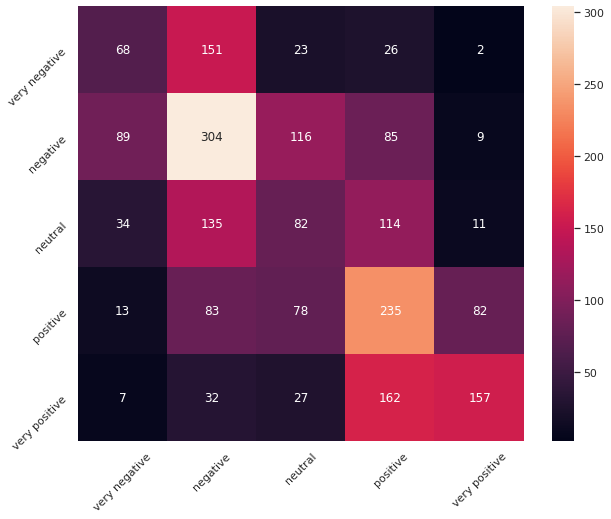

Validating: 0it [00:00, ?it/s]

Test Epoch 9/9: F1 Score: 0.38965, Precision: 0.38578, Recall: 0.37095

Classification Report
               precision    recall  f1-score   support

very negative       0.35      0.27      0.30       270
     negative       0.44      0.42      0.43       603
      neutral       0.23      0.19      0.21       376
     positive       0.36      0.52      0.43       491
very positive       0.55      0.45      0.50       385

     accuracy                           0.39      2125
    macro avg       0.39      0.37      0.37      2125
 weighted avg       0.39      0.39      0.39      2125



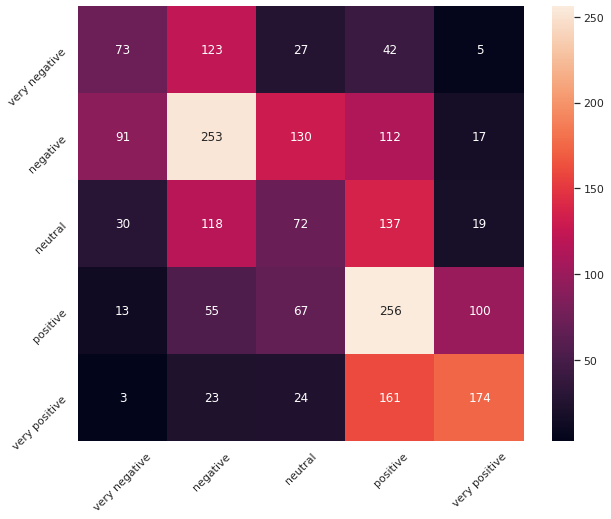

In [ ]:
trainer.fit(sst_model, sst_dataset)